In [1]:
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm

In [2]:
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

len(train_dataset), len(test_dataset)

(60000, 10000)

In [3]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

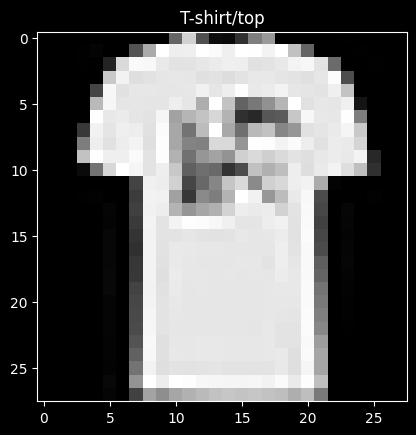

In [4]:
image, label = train_dataset[torch.randint(0, len(train_dataset) - 1, size=[1]).item()]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

image.shape, image.squeeze().shape

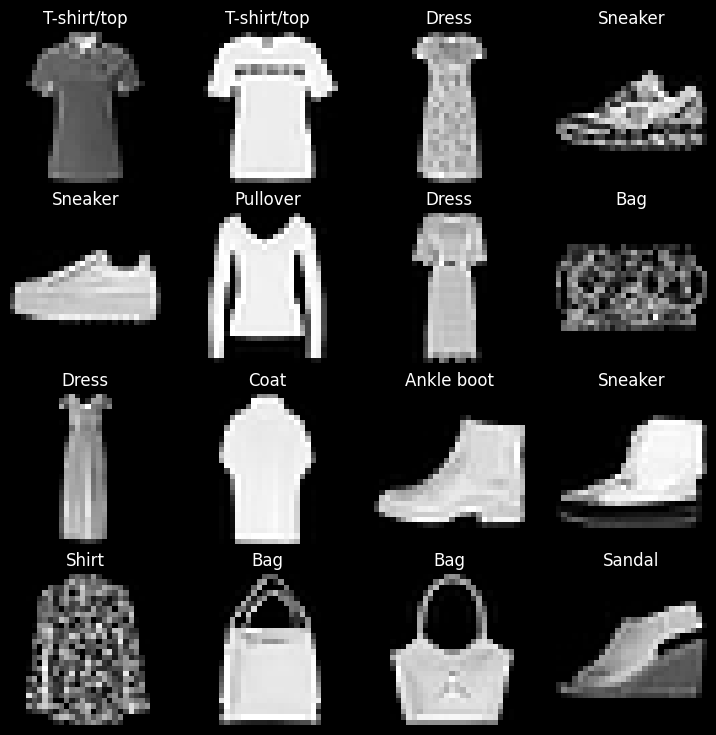

In [5]:
fig = plt.figure(figsize=(9, 9))
rows = cols = 4
for row in range(1, rows * cols + 1):
    rand_idx = torch.randint(0, len(train_dataset) - 1, size=(1,)).item()
    image, label = train_dataset[rand_idx]
    fig.add_subplot(rows, cols, row)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

len(test_dataloader), len(test_dataloader.dataset), len(test_dataset), len(train_dataloader), len(
    train_dataloader.dataset), len(train_dataset)

(313, 10000, 10000, 1875, 60000, 60000)

In [7]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 5, label size: torch.Size([])


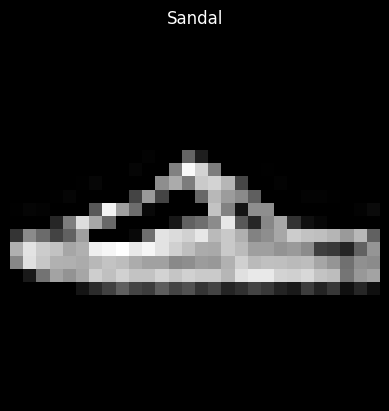

In [8]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


In [9]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [10]:
class FashionMNLISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape),
        )

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(tensor)

In [11]:
model = FashionMNLISTModel(input_shape=28 * 28, hidden_units=10, output_shape=len(train_dataset.classes))
model.to("cpu")

FashionMNLISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [14]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [15]:
torch.manual_seed(42)
start_cpu = timer()

epochs = 3
for epoch in range(epochs):
    train_loss = 0

    for batch, (x, y) in enumerate(train_dataloader):
        train_pred = model(x)
        loss = loss_fn(train_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (x, y) in enumerate(test_dataloader):
            test_pred = model(x)
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

end_cpu = timer()
total_train_time_cpu = print_train_time(start=start_cpu,
                                        end=end_cpu,
                                        device=next(model.parameters()).device)

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 3.34944 | Test loss: 3.02971, Test acc: 70.10%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 3.47665 | Test loss: 3.93958, Test acc: 71.38%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 3.36857 | Test loss: 4.52801, Test acc: 70.33%

Train time on cpu: 9.631 seconds


In [16]:
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acc_fn,
               device: torch.device = "cpu"):
    loss, acc = 0, 0
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss += loss_fn(pred, y).item()
            acc += accuracy_fn(y_true=y, y_pred=pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}


model_res = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, acc_fn=accuracy_fn)
model_res

{'model_name': 'FashionMNLISTModel',
 'model_loss': 4.52312345512378,
 'model_acc': 70.33746006389777}

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
class FashionMNLISTModel2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [19]:
torch.manual_seed(42)
model_1 = FashionMNLISTModel2(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)
                              ).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [21]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)
                                    )

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [22]:
torch.manual_seed(42)

train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(data_loader=train_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn
               )
    test_step(data_loader=test_dataloader,
              model=model_1,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn
              )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95690 | Test accuracy: 64.98%

Train loss: 0.73779 | Train accuracy: 73.69%
Test loss: 0.72388 | Test accuracy: 74.21%

Train loss: 0.66776 | Train accuracy: 76.08%
Test loss: 0.68751 | Test accuracy: 75.64%

Train time on cuda: 10.403 seconds


In [23]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             acc_fn=accuracy_fn,
                             device=device)
model_1_results

{'model_name': 'FashionMNLISTModel2',
 'model_loss': 0.6873753772566493,
 'model_acc': 75.64896166134186}

In [24]:
class FashionMNLISTCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model = FashionMNLISTCNN(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model

FashionMNLISTCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [27]:
epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
for epoch in tqdm(range(epochs)):
    train_step(data_loader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn,
               device=device)
    test_step(data_loader=test_dataloader, model=model, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.57770 | Train accuracy: 79.10%
Test loss: 0.39903 | Test accuracy: 85.22%

Train loss: 0.35551 | Train accuracy: 87.11%
Test loss: 0.37500 | Test accuracy: 86.24%

Train loss: 0.31498 | Train accuracy: 88.66%
Test loss: 0.31622 | Test accuracy: 88.60%



In [28]:
cnn_res = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, acc_fn=accuracy_fn, device=device)
cnn_res

{'model_name': 'FashionMNLISTCNN',
 'model_loss': 0.3164905994392622,
 'model_acc': 88.58825878594249}

In [39]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    with torch.inference_mode():
        model.to(device)
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            print("sample", sample.shape)
            pred_logits = model(sample)
            print("pred_log", pred_logits.shape)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            print("pred_prob", pred_prob.shape, )
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [40]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(
    f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [41]:
pred_probs = make_predictions(model=model,
                              data=test_samples)

pred_probs[:2]

sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])
sample torch.Size([1, 1, 28, 28])
pred_log torch.Size([1, 10])
pred_prob torch.Size([10])


tensor([[5.2712e-08, 1.1449e-10, 1.2703e-09, 1.3595e-09, 1.5862e-08, 9.9997e-01,
         5.0310e-07, 2.7771e-06, 7.2140e-07, 2.7574e-05],
        [8.9808e-02, 6.6119e-01, 1.0174e-03, 6.9172e-02, 7.3947e-02, 2.5452e-04,
         1.0424e-01, 1.5329e-04, 1.8977e-04, 2.6468e-05]])

In [42]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [43]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

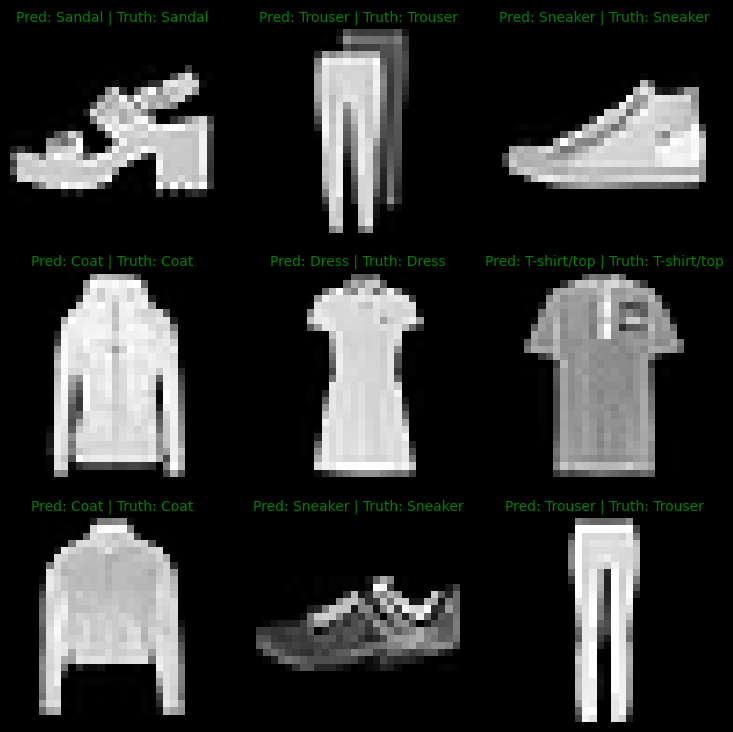

In [44]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)